The first few attempts have lead to issues - one epoch trains for a very very long time, and never completes.  This is due to not giving a set steps_per_epoch, so this next version will include this and Early Stopping.

In [1]:
import tensorflow as tf
import pickle
from tensorflow.keras.layers import StringLookup
from tensorflow.keras import layers, Model
import pandas as pd
import random
import collections
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn.model_selection import train_test_split
from collections import defaultdict

2025-05-23 00:45:28.023419: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-23 00:45:28.162056: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747986328.214316   41998 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747986328.229278   41998 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747986328.339123   41998 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
batch_tunes = 16
# the number of settings per tune
per_tune = 2
batch_size = 32

# Hyperparameters
EMB_DIM    = 64
RNN_UNITS = 64

In [3]:
# load the dataset
df = pd.read_pickle('data/tokenized_dataset.pkl')
# time to remove tunes with only one setting - at least for training triplet loss
counts = df.tune_id.value_counts()
good_ids = counts[counts >= per_tune].index
df = df[df.tune_id.isin(good_ids)]


In [4]:
# build the vocab
all_notes = sorted({n for seq in df.note_seq for n in seq})
note_lookup = tf.keras.layers.StringLookup(
    vocabulary=all_notes,
    mask_token=None,    # 0 will be reserved for padding
    oov_token="[UNK]"
)
df['note_ids'] = df.note_seq.apply(lambda seq: note_lookup(seq).numpy().tolist())


I0000 00:00:1747986332.020354   41998 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9


In [5]:
from sklearn.model_selection import train_test_split

# 1. Get the unique tune IDs
all_tune_ids = df.tune_id.unique()

# 2. Split off test (10%)
trainval_ids, test_ids = train_test_split(
    all_tune_ids, test_size=0.10, random_state=42
)

# 3. Split train vs validation (of the remaining 90%)
train_ids, val_ids = train_test_split(
    trainval_ids, test_size=0.11, random_state=42
)
# 0.11 of 90% ≈ 10% of original, so you end up ~80/10/10
df_train = df[df.tune_id.isin(train_ids)]
df_val   = df[df.tune_id.isin(val_ids)]
df_test  = df[df.tune_id.isin(test_ids)]

val_steps  = len(df_val) // batch_size

steps_per_epoch = len(df_train) // batch_size

In [6]:
def make_balanced_ds(df_split, batch_tunes=16, per_tune=2):
    # Build index: tune_id → list of (notes, durs)
    by_id = defaultdict(list)
    for notes, durs, tid in zip(df_split.note_ids, df_split.dur_seq, df_split.tune_id):
        by_id[int(tid)].append((notes, durs))

    # Only include tunes with at least `per_tune` settings
    eligible_tune_ids = [tid for tid, settings in by_id.items() if len(settings) >= per_tune]

    def gen():
        while True:
            # Randomly sample `batch_tunes` *unique* tune IDs
            chosen_tunes = random.sample(eligible_tune_ids, batch_tunes)
            for tid in chosen_tunes:
                # Sample `per_tune` *unique* settings for this tune
                examples = random.sample(by_id[tid], per_tune)
                for notes, durs in examples:
                    yield (notes, durs), tid

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            (
                tf.TensorSpec(shape=(None,), dtype=tf.int32),   # notes_list
                tf.TensorSpec(shape=(None,), dtype=tf.float32)  # durs_list
            ),
            tf.TensorSpec(shape=(), dtype=tf.int32)            # label
        )
    ).padded_batch(
        batch_size=batch_tunes * per_tune,
        padded_shapes=(
            ([None], [None]),  # notes and durs
            []                 # label
        ),
        padding_values=(
            (0, 0.0),          # pad notes and durs
            0                  # pad label
        )
    ).prefetch(tf.data.AUTOTUNE)

    return ds


train_ds = make_balanced_ds(df_train)
val_ds   = make_balanced_ds(df_val)



In [7]:
def pairwise_distances(embeddings):
    # embeddings: [batch, dim]
    # returns a [batch, batch] matrix of squared distances
    dot = tf.matmul(embeddings, embeddings, transpose_b=True)
    sq = tf.reduce_sum(tf.square(embeddings), axis=1, keepdims=True)
    # d(i,j) = ||xi - xj||^2 = sq[i] - 2*dot[i,j] + sq[j]
    return tf.maximum(sq - 2.0 * dot + tf.transpose(sq), 0.0)

def batch_hard_triplet_loss(margin=0.3):
    def loss_fn(y_true, y_pred):
        # y_true: [batch] int labels (tune_id)
        # y_pred: [batch, dim] embeddings (already ℓ₂‐normalized or not)
        labels = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        embeddings = y_pred
        # 1) Pairwise distance matrix
        pdist = pairwise_distances(embeddings)
        # 2) Masks for positive / negative pairs
        labels_eq = tf.equal(tf.expand_dims(labels,1), tf.expand_dims(labels,0))  # [B,B]
        mask_pos = tf.cast(labels_eq, tf.float32) - tf.eye(tf.shape(labels)[0])   # zero diagonal
        mask_neg = 1.0 - tf.cast(labels_eq, tf.float32)

        # 3) For each anchor i, hardest positive = max_{j!=i, same label} d(i,j)
        hardest_pos = tf.reduce_max(pdist * mask_pos, axis=1)
        # 4) For each anchor i, easiest negative = min_{k, different label} d(i,k)
        #    to do that, add large constant to positives so they’re ignored in min()
        max_dist = tf.reduce_max(pdist)
        pdist_neg = pdist + max_dist * (1.0 - mask_neg)
        hardest_neg = tf.reduce_min(pdist_neg, axis=1)

        # 5) Combine with margin
        tl = tf.maximum(hardest_pos - hardest_neg + margin, 0.0)
        return tf.reduce_mean(tl)
    return loss_fn


In [8]:
vocab_list = note_lookup.get_vocabulary()
VOCAB_SIZE = len(vocab_list) + 2  
# 1) Define your two inputs
notes_in = layers.Input(shape=(None,), dtype="int32",   name="note_ids")
durs_in  = layers.Input(shape=(None,), dtype="float32", name="durations")

# 2) Embed your notes (this is trainable, starts random)
note_emb = layers.Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMB_DIM,
    mask_zero=True,   # so padding=0 is ignored by downstream RNN
)(notes_in)          # → shape (batch, timesteps, EMB_DIM)

dur_feat = layers.Lambda(
    lambda x: tf.expand_dims(x, -1),
    mask=lambda inputs, mask: mask  # pass the incoming 2D mask straight through
)(durs_in)
# project durations into EMB_DIM via a Dense layer
dur_emb = layers.TimeDistributed(layers.Dense(EMB_DIM))(dur_feat)
# now both note_emb and dur_emb are (B, T, EMB_DIM)
x = layers.Add()([note_emb, dur_emb])

# → shape (batch, timesteps, EMB_DIM + 1)

# 5) Encode with a Bidirectional GRU (return_sequences=True so we can pool)
rnn_out = layers.Bidirectional(
    layers.GRU(RNN_UNITS, return_sequences=True)
)(x)
# → shape (batch, timesteps, 2*RNN_UNITS)

# 6) Pool across time (takes care of variable lengths & masks)
tune_vec = layers.GlobalAveragePooling1D()(rnn_out)
# → shape (batch, 2*RNN_UNITS)

# 7) L2-normalize if you like (makes cosine‐based losses stable)
tune_emb = layers.Lambda(lambda z: tf.math.l2_normalize(z, axis=1))(tune_vec)

# 8) Build & compile
model = Model(inputs=[notes_in, durs_in], outputs=tune_emb)
model.compile(
    optimizer="adam",
    loss=batch_hard_triplet_loss(margin=0.3)
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ durations           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ note_ids            │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, None, 1)   │          0 │ durations[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 64)  │      4,224 │ note_ids[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None, 64)  │        128 │ lambda[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 64)  │          0 │ embedding[0][0],  │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, None, 128) │     49,920 │ add[0][0]         │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ bidirectional[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128)       │          0 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,272 (212.00 KB)

 Trainable params: 54,272 (212.00 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:

callbacks = [
  ModelCheckpoint(
    "saved_models/ckpt_1_{epoch:02d}.weights.h5",
    save_weights_only=True,
    save_best_only=True,
    monitor="loss",
  ),
  EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
  ),
  TensorBoard(log_dir="logs/v1/"),
]


In [10]:
history = model.fit(train_ds, epochs=100, steps_per_epoch=steps_per_epoch, validation_data = val_ds, validation_steps = len(df_val), callbacks=callbacks)

Epoch 1/100


I0000 00:00:1747986381.507531   42172 cuda_dnn.cc:529] Loaded cuDNN version 90300


944/944 ━━━━━━━━━━━━━━━━━━━━ 118s 123ms/step - loss: 0.2999 - val_loss: 0.3028
Epoch 2/100
944/944 ━━━━━━━━━━━━━━━━━━━━ 112s 119ms/step - loss: 0.2777 - val_loss: 0.1588
Epoch 3/100
944/944 ━━━━━━━━━━━━━━━━━━━━ 111s 117ms/step - loss: 0.1290 - val_loss: 0.1269
Epoch 4/100
944/944 ━━━━━━━━━━━━━━━━━━━━ 113s 120ms/step - loss: 0.1052 - val_loss: 0.1193
Epoch 5/100
944/944 ━━━━━━━━━━━━━━━━━━━━ 113s 119ms/step - loss: 0.0934 - val_loss: 0.1162
Epoch 6/100
944/944 ━━━━━━━━━━━━━━━━━━━━ 111s 118ms/step - loss: 0.0878 - val_loss: 0.1113
Epoch 7/100
944/944 ━━━━━━━━━━━━━━━━━━━━ 115s 122ms/step - loss: 0.0794 - val_loss: 0.1116
Epoch 8/100
944/944 ━━━━━━━━━━━━━━━━━━━━ 111s 117ms/step - loss: 0.0755 - val_loss: 0.1064
Epoch 9/100
944/944 ━━━━━━━━━━━━━━━━━━━━ 111s 117ms/step - loss: 0.0688 - val_loss: 0.1100
Epoch 10/100
944/944 ━━━━━━━━━━━━━━━━━━━━ 112s 119ms/step - loss: 0.0675 - val_loss: 0.1127
Epoch 11/100
944/944 ━━━━━━━━━━━━━━━━━━━━ 115s 122ms/step - loss: 0.0638 - val_loss: 0.1090
Epoch 12/

In [11]:
# after training…
model.save("saved_models/tune_embedder_v1_fixed_batching_100_epoch.keras")  
# → creates a SavedModel directory you can reload anywhere


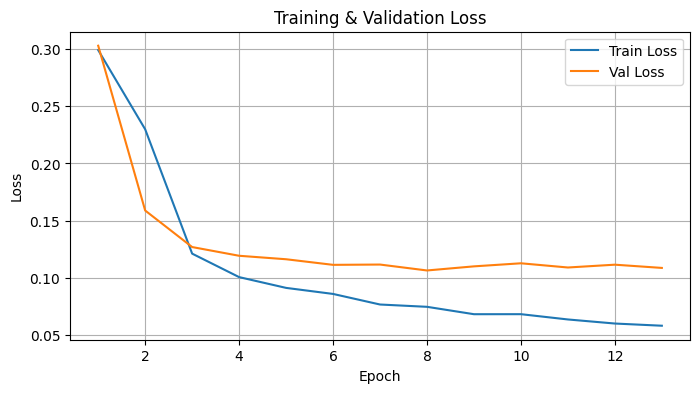

In [12]:
import matplotlib.pyplot as plt

# history is the History object returned by model.fit(...)
train_loss = history.history['loss']
val_loss   = history.history.get('val_loss', None)
epochs     = range(1, len(train_loss) + 1)

plt.figure(figsize=(8,4))
plt.plot(epochs, train_loss,  label='Train Loss')
if val_loss is not None:
    plt.plot(epochs, val_loss,  label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


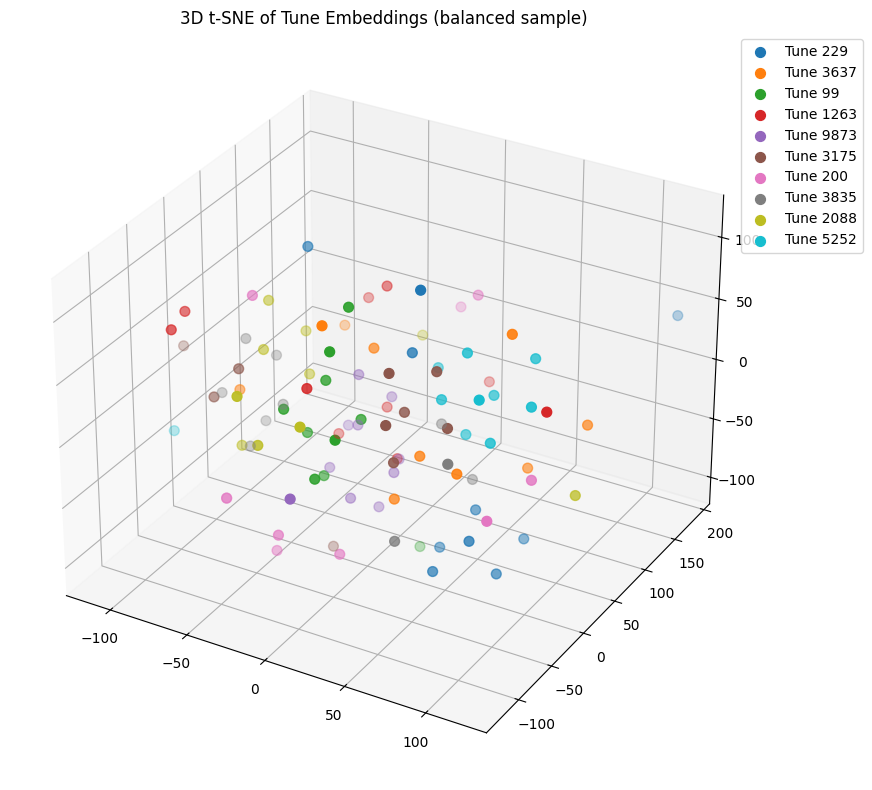

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold     import TSNE
import seaborn as sns
import pandas as pd


# ---- A) Pull one balanced‐batch of examples ----
viz_ds = make_balanced_ds(df_val, batch_tunes=10, per_tune =10)
(v_notes, v_durs), labels_sub = next(iter(viz_ds.take(1)))

# ---- B) Compute embeddings for that batch ----
emb_sub = model.predict([v_notes, v_durs])

# # ---- C) 2D PCA plot ----
# coords2 = PCA(n_components=2).fit_transform(emb_sub)
# plt.figure(figsize=(6,6))
# sc = plt.scatter(coords2[:,0], coords2[:,1],
#                  c=labels_sub, cmap='tab10', s=30)
# plt.title("2D PCA of Tune Embeddings (balanced sample)")
# plt.xlabel("PC1"); plt.ylabel("PC2")
# plt.colorbar(sc, label='tune_id')
# plt.show()

# ---- D) 3D t-SNE plot (optional) ----
# Prepare DataFrame for seaborn
coords3 = TSNE(n_components=3, random_state=42).fit_transform(emb_sub)

df_tsne = pd.DataFrame({
    'Dim1': coords3[:, 0],
    'Dim2': coords3[:, 1],
    'Dim3': coords3[:, 2],
    'tune_id': labels_sub.numpy() if hasattr(labels_sub, 'numpy') else labels_sub
})

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a scatter plot for each unique tune_id
for tune_id in df_tsne['tune_id'].unique():
    mask = df_tsne['tune_id'] == tune_id
    ax.scatter(df_tsne.loc[mask, 'Dim1'], 
              df_tsne.loc[mask, 'Dim2'], 
              df_tsne.loc[mask, 'Dim3'],
              label=f'Tune {tune_id}',
              s=50)

ax.set_title("3D t-SNE of Tune Embeddings (balanced sample)")

# Add legend with tune IDs
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.show()
